# Evaluation of Diagnostic Models

In this assignment, we will be working with the results of the X-ray classification model we developed in the previous assignment. In order to make the data processing a bit more manageable, we will be working with a subset of our training, and validation datasets. We will also use our manually labeled test dataset of 420 X-rays.  

As a reminder, our dataset contains X-rays from 14 different conditions diagnosable from an X-ray. We'll evaluate our performance on each of these classes using the classification metrics we learned in lecture.

## Outline
Click on these links to jump to a particular section of this assignment!
- [1. Packages](#1)
- [2. Overview](#2)
- [3. Metrics](#3)
    - [3.1 True Positives, False Positives, True Negatives, and False Negatives](#3-1)
    - [3.2 Accuracy](#3-2)
    - [3.3 Prevalence](#3-3)
    - [3.4 Sensitivity and Specificity](#3-4)
    - [3.5 PPV and NPV](#3-5)
    - [3.6 ROC Curve](#3-6)
- [4. Confidence Intervals](#4)
- [5. Precision-Recall Curve](#5)
- [6. F1 Score](#6)
- [7. Calibration](#7)

<a name='1'></a>
## 1. Packages

In this assignment, we'll make use of the following packages:
- [numpy](https://docs.scipy.org/doc/numpy/) is a popular library for scientific computing
- [matplotlib](https://matplotlib.org/3.1.1/contents.html) is a plotting library compatible with numpy
- [pandas](https://pandas.pydata.org/docs/) is what we'll use to manipulate our data
- [sklearn](https://scikit-learn.org/stable/index.html) will be used to measure the performance of our model


Run the next cell to import all the necessary packages as well as custom util functions.

In [2]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd  

import util

<a name='2'></a>
## 2. Overview

We'll go through our evaluation metrics in the following order.

- Metrics
  - TP, TN, FP, FN
  - Accuracy
  - Prevalence
  - Sensitivity and Specificity
  - PPV and NPV
  - AUC
- Confidence Intervals

Let's take a quick peek at our dataset. The data is stored in two CSV files called `train_preds.csv` and `valid_preds.csv`. We have precomputed the model outputs for our test cases. We'll work with these predictions and the true class labels throughout the assignment.

In [5]:
train_results = pd.read_csv("train_preds.csv")
valid_results = pd.read_csv("valid_preds.csv")

# the labels in our dataset
class_labels = ['Cardiomegaly',
 'Emphysema',
 'Effusion',
 'Hernia',
 'Infiltration',
 'Mass',
 'Nodule',
 'Atelectasis',
 'Pneumothorax',
 'Pleural_Thickening',
 'Pneumonia',
 'Fibrosis',
 'Edema',
 'Consolidation']

# the labels for prediction values in our dataset
pred_labels = [l + "_pred" for l in class_labels]
pred_labels

['Cardiomegaly_pred',
 'Emphysema_pred',
 'Effusion_pred',
 'Hernia_pred',
 'Infiltration_pred',
 'Mass_pred',
 'Nodule_pred',
 'Atelectasis_pred',
 'Pneumothorax_pred',
 'Pleural_Thickening_pred',
 'Pneumonia_pred',
 'Fibrosis_pred',
 'Edema_pred',
 'Consolidation_pred']

In [6]:
y = valid_results[class_labels].values
pred = valid_results[pred_labels].values

# let's take a peek at our dataset
valid_results[np.concatenate([class_labels, pred_labels])].head()

,Cardiomegaly,Emphysema,Effusion,Hernia,Infiltration,Mass,Nodule,Atelectasis,Pneumothorax,Pleural_Thickening,...,Infiltration_pred,Mass_pred,Nodule_pred,Atelectasis_pred,Pneumothorax_pred,Pleural_Thickening_pred,Pneumonia_pred,Fibrosis_pred,Edema_pred,Consolidation_pred
0,0,0,0,0,0,0,0,0,0,0,...,0.256020,0.266928,0.312440,0.460342,0.079453,0.271495,0.276861,0.398799,0.015867,0.156320
1,0,0,0,0,1,0,1,0,0,0,...,0.382199,0.176825,0.465807,0.489424,0.084595,0.377317,0.363582,0.638024,0.025948,0.144419
2,0,0,0,0,0,0,0,0,0,0,...,0.427727,0.115513,0.249030,0.035105,0.238761,0.167095,0.166389,0.262463,0.007758,0.125790
3,0,0,0,0,0,0,0,0,0,0,...,0.158596,0.259460,0.334870,0.266489,0.073371,0.229834,0.191281,0.344348,0.008559,0.119153
4,0,0,0,0,0,0,0,0,0,0,...,0.536762,0.198797,0.273110,0.186771,0.242122,0.309786,0.411771,0.244666,0.126930,0.342409


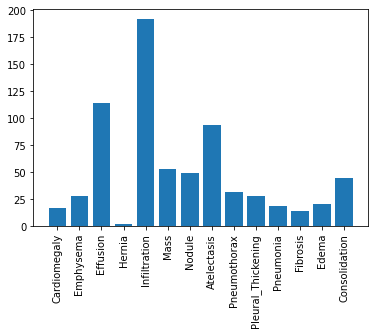

In [7]:
plt.xticks(rotation=90)
plt.bar(x = class_labels, height= y.sum(axis=0));

<a name='3'></a>
## 3 Metrics

<a name='3-1'></a>
### 3.1 True Positives, False Positives, True Negatives, and False Negatives

The most basic statistics to compute from the model predictions are the true positives, true negatives, false positives, and false negatives. 

As the name suggests
- true positive (TP): The model classifies the example as positive, and the actual label also positive.
- false positive (FP): The model classifies the example as positive, **but** the actual label is negative.
- true negative (TN): The model classifies the example as negative, and the actual label is also negative.
- false negative (FN): The model classifies the example as negative, **but** the label is actually positive.

We will count the number of TP, FP, TN and FN in the given data.  All of our metrics can be built off of these four statistics. 

Recall that the model outputs real numbers between 0 and 1.
* To compute binary class predictions, we need to convert these to either 0 or 1. 
* We'll do this using a threshold value $th$.
* Any model outputs above $th$ are set to 1, and below $th$ are set to 0. 

All of our metrics (except for AUC at the end) will depend on the choice of this threshold. 

Fill in the functions to compute the TP, FP, TN, and FN for a given threshold below. 

The first one has been done for you.

In [8]:
# UNQ_C1 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def true_positives(y, pred, th=0.5):
    """
    Count true positives.

    Args:
        y (np.array): ground truth, size (n_examples)
        pred (np.array): model output, size (n_examples)
        th (float): cutoff value for positive prediction from model
    Returns:
        TP (int): true positives
    """
    TP = 0
    
    # get thresholded predictions
    thresholded_preds = pred >= th

    # compute TP
    TP = np.sum((y == 1) & (thresholded_preds == 1))
    
    return TP

def true_negatives(y, pred, th=0.5):
    """
    Count true negatives.

    Args:
        y (np.array): ground truth, size (n_examples)
        pred (np.array): model output, size (n_examples)
        th (float): cutoff value for positive prediction from model
    Returns:
        TN (int): true negatives
    """
    TN = 0
    
    # get thresholded predictions
    thresholded_preds = pred >= th

    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
    # compute TN
    TN = np.sum((y==0) & (thresholded_preds==0))
    
    ### END CODE HERE ###
    
    return TN

def false_positives(y, pred, th=0.5):
    """
    Count false positives.

    Args:
        y (np.array): ground truth, size (n_examples)
        pred (np.array): model output, size (n_examples)
        th (float): cutoff value for positive prediction from model
    Returns:
        FP (int): false positives
    """
    FP = 0
    
    # get thresholded predictions
    thresholded_preds = pred >= th
    
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###

    # compute FP
    FP = np.sum((y==0) & (thresholded_preds==1))
    
    ### END CODE HERE ###
    
    return FP

def false_negatives(y, pred, th=0.5):
    """
    Count false positives.

    Args:
        y (np.array): ground truth, size (n_examples)
        pred (np.array): model output, size (n_examples)
        th (float): cutoff value for positive prediction from model
    Returns:
        FN (int): false negatives
    """
    FN = 0
    
    # get thresholded predictions
    thresholded_preds = pred >= th

    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
    # compute FN
    FN = np.sum((y==1) & (thresholded_preds==0))
    
    ### END CODE HERE ###
    
    return FN

<a name='3-2'></a>
### 3.2 Accuracy


Let's use a threshold of .5 for the probability cutoff for our predictions for all classes and calculate our model's accuracy as we would normally do in a machine learning problem. 

$$accuracy = \frac{\text{true positives} + \text{true negatives}}{\text{true positives} + \text{true negatives} + \text{false positives} + \text{false negatives}}$$

Use this formula to compute accuracy below:

In [9]:
# UNQ_C2 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def get_accuracy(y, pred, th=0.5):
    """
    Compute accuracy of predictions at threshold.

    Args:
        y (np.array): ground truth, size (n_examples)
        pred (np.array): model output, size (n_examples)
        th (float): cutoff value for positive prediction from model
    Returns:
        accuracy (float): accuracy of predictions at threshold
    """
    accuracy = 0.0
    
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
    # get TP, FP, TN, FN using our previously defined functions
    TP = true_positives(y, pred, th)
    FP = false_positives(y, pred, th)
    TN = true_negatives(y, pred, th)
    FN = false_negatives(y, pred, th)

    # Compute accuracy using TP, FP, TN, FN
    accuracy = (TP+TN)/(TP+FP+TN+FN)
    
    ### END CODE HERE ###
    
    return accuracy

<a name='3-3'></a>
### 3.3 Prevalence
Another important concept is **prevalence**. 
* In a medical context, prevalence is the proportion of people in the population who have the disease (or condition, etc). 
* In machine learning terms, this is the proportion of positive examples. The expression for prevalence is:

$$prevalence = \frac{1}{N} \sum_{i} y_i$$

where $y_i = 1$ when the example is 'positive' (has the disease).

Let's measure prevalence for each disease:

In [10]:
# UNQ_C3 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def get_prevalence(y):
    """
    Compute prevalence.

    Args:
        y (np.array): ground truth, size (n_examples)
    Returns:
        prevalence (float): prevalence of positive cases
    """
    prevalence = 0.0
    
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
    prevalence = np.sum(y)
    
    ### END CODE HERE ###
    
    return prevalence

<a name='3-4'></a>
### 3.4 Sensitivity and Specificity
<img src="sens_spec.png" width="30%">

Sensitivity and specificity are two of the most prominent numbers that are used to measure diagnostics tests.
- Sensitivity is the probability that our test outputs positive given that the case is actually positive.
- Specificity is the probability that the test outputs negative given that the case is actually negative. 

We can phrase this easily in terms of true positives, true negatives, false positives, and false negatives: 

$$sensitivity = \frac{\text{true positives}}{\text{true positives} + \text{false negatives}}$$

$$specificity = \frac{\text{true negatives}}{\text{true negatives} + \text{false positives}}$$

Let's calculate sensitivity and specificity for our model:

In [11]:
# UNQ_C4 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def get_sensitivity(y, pred, th=0.5):
    """
    Compute sensitivity of predictions at threshold.

    Args:
        y (np.array): ground truth, size (n_examples)
        pred (np.array): model output, size (n_examples)
        th (float): cutoff value for positive prediction from model
    Returns:
        sensitivity (float): probability that our test outputs positive given that the case is actually positive
    """
    sensitivity = 0.0
    
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
    # get TP and FN using our previously defined functions
    TP = true_positives(y, pred, th)
    FN = false_negatives(y, pred, th)

    # use TP and FN to compute sensitivity
    sensitivity = TP/(TP+FN)
    
    ### END CODE HERE ###
    
    return sensitivity

def get_specificity(y, pred, th=0.5):
    """
    Compute specificity of predictions at threshold.

    Args:
        y (np.array): ground truth, size (n_examples)
        pred (np.array): model output, size (n_examples)
        th (float): cutoff value for positive prediction from model
    Returns:
        specificity (float): probability that the test outputs negative given that the case is actually negative
    """
    specificity = 0.0
    
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
    # get TN and FP using our previously defined functions
    TN = true_negatives(y, pred, th)
    FP = false_positives(y, pred, th)
    
    # use TN and FP to compute specificity 
    specificity = TN/(TN+FP)
    
    ### END CODE HERE ###
    
    return specificity

<a name='3-5'></a>
### 3.5 PPV and NPV

Diagnostically, however, sensitivity and specificity are not helpful. Sensitivity, for example, tells us the probability our test outputs positive given that the person already has the condition. Here, we are conditioning on the thing we would like to find out (whether the patient has the condition)!

What would be more helpful is the probability that the person has the disease given that our test outputs positive. That brings us to positive predictive value (PPV) and negative predictive value (NPV).

- Positive predictive value (PPV) is the probability that subjects with a positive screening test truly have the disease.
- Negative predictive value (NPV) is the probability that subjects with a negative screening test truly don't have the disease.

Again, we can formulate these in terms of true positives, true negatives, false positives, and false negatives: 

$$PPV = \frac{\text{true positives}}{\text{true positives} + \text{false positives}}$$ 

$$NPV = \frac{\text{true negatives}}{\text{true negatives} + \text{false negatives}}$$


Let's calculate PPV & NPV for our model:

In [14]:
# UNQ_C5 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def get_ppv(y, pred, th=0.5):
    """
    Compute PPV of predictions at threshold.

    Args:
        y (np.array): ground truth, size (n_examples)
        pred (np.array): model output, size (n_examples)
        th (float): cutoff value for positive prediction from model
    Returns:
        PPV (float): positive predictive value of predictions at threshold
    """
    PPV = 0.0
    
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
    # get TP and FP using our previously defined functions
    TP = true_positives(y, pred, th)
    FP = false_positives(y, pred, th)

    # use TP and FP to compute PPV
    PPV = TP/(TP+FP)
    
    ### END CODE HERE ###
    
    return PPV

def get_npv(y, pred, th=0.5):
    """
    Compute NPV of predictions at threshold.

    Args:
        y (np.array): ground truth, size (n_examples)
        pred (np.array): model output, size (n_examples)
        th (float): cutoff value for positive prediction from model
    Returns:
        NPV (float): negative predictive value of predictions at threshold
    """
    NPV = 0.0
    
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
    # get TN and FN using our previously defined functions
    TN = true_negatives(y, pred, th)
    FN = false_negatives(y, pred, th)

    # use TN and FN to compute NPV
    NPV = TN/(TN+FN)
    
    ### END CODE HERE ###
    
    return NPV

<a name='3-6'></a>
### 3.6 ROC Curve

So far we have been operating under the assumption that our model's prediction of `0.5` and above should be treated as positive and otherwise it should be treated as negative. This however was a rather arbitrary choice. One way to see this, is to look at a very informative visualization called the receiver operating characteristic (ROC) curve.

The ROC curve is created by plotting the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings. The ideal point is at the top left, with a true positive rate of 1 and a false positive rate of 0. The various points on the curve are generated by gradually changing the threshold.

Let's look at this curve for our model:

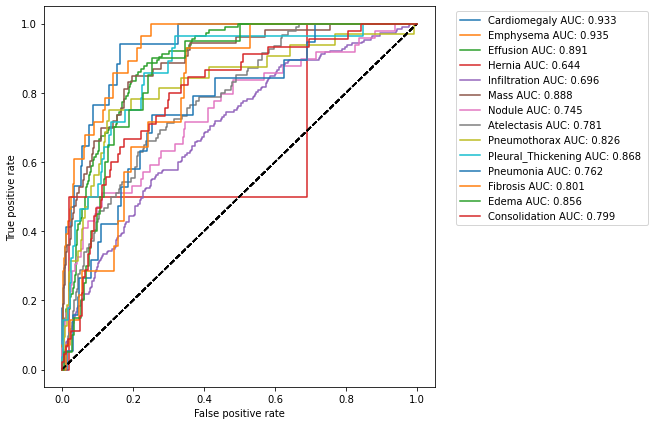

In [15]:
util.get_curve(y, pred, class_labels)

In [16]:
from sklearn.metrics import roc_auc_score
util.get_performance_metrics(y, pred, class_labels, acc=get_accuracy, prevalence=get_prevalence, 
                        sens=get_sensitivity, spec=get_specificity, ppv=get_ppv, npv=get_npv, auc=roc_auc_score)

,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
,,,,,,,,,,,,,
Cardiomegaly,16,814,169,1,0.83,17,0.941,0.828,0.086,0.999,0.933,Not Defined,0.5
Emphysema,20,869,103,8,0.889,28,0.714,0.894,0.163,0.991,0.935,Not Defined,0.5
Effusion,99,690,196,15,0.789,114,0.868,0.779,0.336,0.979,0.891,Not Defined,0.5
Hernia,1,743,255,1,0.744,2,0.5,0.744,0.004,0.999,0.644,Not Defined,0.5
Infiltration,114,543,265,78,0.657,192,0.594,0.672,0.301,0.874,0.696,Not Defined,0.5
Mass,40,789,158,13,0.829,53,0.755,0.833,0.202,0.984,0.888,Not Defined,0.5
Nodule,28,731,220,21,0.759,49,0.571,0.769,0.113,0.972,0.745,Not Defined,0.5
Atelectasis,64,657,249,30,0.721,94,0.681,0.725,0.204,0.956,0.781,Not Defined,0.5
Pneumothorax,24,785,183,8,0.809,32,0.75,0.811,0.116,0.99,0.826,Not Defined,0.5
